In [1]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm



files = Path("agg_data").glob("ParlaMint-*.speeches.jsonl")
files = list(files)
dfs = []


for file in tqdm(files):
  if any([i in str(file) for i in ["ES-CT", "ES-GA", "ES-PV"]]):
    continue
  df = pd.read_json(file,
                    lines=True,
                    # nrows=10000,
                    )
  df["country"] = str(file).split("ParlaMint-")[-1].split(".speeches")[0]
  df = pd.concat([df, df.metadata.apply(pd.Series)], axis=1)
  dfs.append(
    df
  )
df = pd.concat(dfs).reset_index(drop=True)
print(df.shape)

100%|██████████| 29/29 [36:46<00:00, 76.10s/it] 


(8026469, 29)


In [12]:
countries = ["AT", "BA", "BE", "BG", "CZ", "DK", "EE", "ES-CT", "ES-GA", "ES-PV", "ES", "FI", "FR", "GB", "GR", "HR", "HU", "IS", "IT", "LV", "NL", "NO", "PL", "PT", "RS", "SE", "SI", "TR", "UA", ]

lattitudes = [ 47.33, 44, 50.83, 43, 49.75, 56, 59, 40, 40, 40, 40, 64, 46, 54, 39, 45.17, 47, 65, 42.83, 57, 52.5, 62, 52, 39.5, 44, 62, 46, 39, 49,]
mapper = {k: v for k, v in zip(countries, lattitudes)}

In [16]:
df.head(1)

,newdoc id,logits_pondered,logits_averaged,char_length,metadata,country,Text_ID,ID,Title,Date,...,Speaker_MP,Speaker_minister,Speaker_party,Speaker_party_name,Party_status,Party_orientation,Speaker_ID,Speaker_name,Speaker_gender,Speaker_birth
0,ParlaMint-UA_2022-12-13-m0.u1,3.7954,3.878044,4494,"{'Text_ID': 'ParlaMint-UA-en_2022-12-13-m0', '...",UA,ParlaMint-UA-en_2022-12-13-m0,ParlaMint-UA_2022-12-13-m0.u1,Ukrainian parliamentary corpus ParlaMint-UA-en...,2022-12-13,...,MP,notMinister,-,-,-,-,РусланОлексійовичСтефанчук.1975,"Stefančuk, Ruslan Oleksijovyč",M,1975


In [14]:
# Filtering
# Keep only MPs
c1 = df.Speaker_MP == "MP"

# Exclude non-national parliaments:
c2 = ~df.country.isin(["ES-CT", "ES-GA", "ES-PV", ])

# Exclude chairs:
c3 = df.Speaker_role != "Chairperson"

ndf = df[
    # c1 & \
    c2 & \
    c3
    ]

def map_sentiment_to_category(logit: float) -> str:
    if logit < 2:
        return "Negative"
    elif 2 <= logit < 4:
        return "Neutral"
    else:
        return "Positive"
ndf["sentiment_categorical"] = ndf.logits_pondered.apply(map_sentiment_to_category)


def percentage_of_neutral(l: pd.Series) -> float:
    return (l == "Neutral").sum()/l.shape[0]
def percentage_of_negative(l: pd.Series) -> float:
    return (l == "Negative").sum()/l.shape[0]
def percentage_of_positive(l: pd.Series) -> float:
    return (l == "Positive").sum()/l.shape[0]
def get_female_average_per_country(df: pd.DataFrame, country: str)-> float:
    c1 = df.country == country
    c2 = df.Speaker_gender


gb1 = ndf.groupby("country").agg({
    "logits_pondered": "mean",
    "sentiment_categorical": [percentage_of_positive, percentage_of_neutral, percentage_of_negative]
}).reset_index()
gb1.columns = "country average_sentiment percentage_of_positive percentage_of_neutral percentage_of_negative".split()



gb2 = df.groupby(["country", "Speaker_gender"]).agg({
    "logits_pondered": "mean"
}).reset_index()


gb1["average_female_sentiment"] = gb1.merge(gb2[gb2.Speaker_gender == "F"], on="country", how="outer").logits_pondered
gb1["average_male_sentiment"] = gb1.merge(gb2[gb2.Speaker_gender == "M"], on="country", how="outer").logits_pondered
gb1["male - female"] = gb1.average_male_sentiment - gb1.average_female_sentiment
gb1["lattitude"] = [mapper.get(i) for i in gb1.country]
gb1

/tmp/ipykernel_1839890/969940974.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf["sentiment_categorical"] = ndf.logits_pondered.apply(map_sentiment_to_category)


,country,average_sentiment,percentage_of_positive,percentage_of_neutral,percentage_of_negative,average_female_sentiment,average_male_sentiment,male - female,lattitude
0,AT,2.226264,0.038064,0.511451,0.450485,2.764907,2.721288,-0.043619,47.33
1,BA,2.252979,0.049016,0.529578,0.421407,2.431688,2.710036,0.278347,44.00
2,BE,2.107236,0.036177,0.497442,0.466381,2.197582,2.231298,0.033716,50.83
3,BG,2.293922,0.070280,0.532885,0.396835,2.952112,2.658255,-0.293856,43.00
4,CZ,2.181011,0.029425,0.518337,0.452238,2.702912,2.723284,0.020372,49.75
5,DK,2.002573,0.036078,0.436737,0.527185,2.816412,2.661375,-0.155037,56.00
6,EE,1.918771,0.012029,0.430717,0.557254,2.380009,2.353652,-0.026357,59.00
7,ES,1.908814,0.057364,0.358363,0.584273,2.253886,2.194448,-0.059438,40.00
8,FI,2.256924,0.043025,0.540523,0.416452,2.404578,2.423959,0.019381,64.00
9,FR,2.185810,0.073711,0.511203,0.415086,2.336121,2.209049,-0.127073,46.00


/home/peterr/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


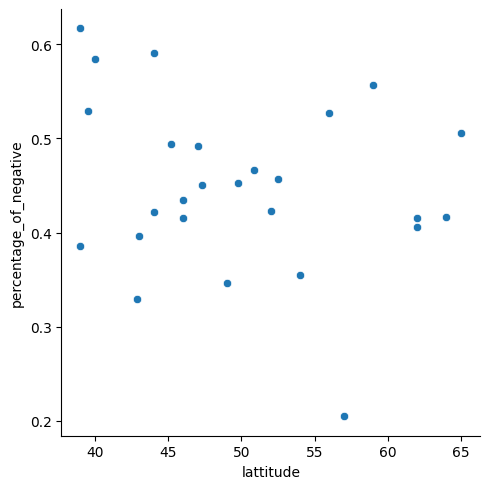

In [15]:
import seaborn as sns

sns.relplot(
    data=gb1,
    x="lattitude",
    y="percentage_of_negative",
    kind="scatter",
)